# August 10, 2022: generate trial level responses of MAX data for ABA rois

In [1]:
import os 
import sys
from os.path import join as pjoin
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import pickle, random

from nltools import mask
from nilearn import image, masking

# plotting
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr #CITE ITS PAPER IN YOUR MANUSCRIPT

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'network_dynamics')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/aug22"

# folders
sys.path.insert(0, proj_dir)
import helpers.dataset_utils as dataset_utils

/home/govindas/venvs/expln-ai3.9/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


## set of rois

In [2]:
set_name = 'aba'
mask_dir = f"{proj_dir}/data/rois/{set_name}"
mask_df = pd.read_csv(
    f"/home/govindas/vscode-BSWIFT-mnt/ABA/ROI_mask/ABA_36ROIs_gm.txt",
    delimiter='\t'
)
display(mask_df)

final_mask_file = f"/home/govindas/vscode-BSWIFT-mnt/ABA/ROI_mask/ABA_ROIs_final_gm_36.nii.gz"

,sHemi,ROI,Index,Voxels,File_Name,Network_name,Network_Ref
0,R,Hypothalamus,1,169.0,Caltech_r-HTH-2mm_gm_clipped.nii.gz,NaN,NaN
1,L,Hypothalamus,2,148.0,Caltech_l-HTH-2mm_gm_clipped.nii.gz,NaN,NaN
2,R,ACC,3,346.0,r-ACC_BN_Atlas_2mm_clipped_midlineEX.nii.gz,NaN,NaN
3,L,ACC,4,364.0,l-ACC_BN_Atlas_2mm_clipped_midlineEX.nii.gz,NaN,NaN
4,R,ant. MCC,5,382.0,cingulate_mid_anterior_DD_left_2mm_midlineExcl...,NaN,NaN
5,L,ant. MCC,6,302.0,cingulate_mid_anterior_DD_left_2mm_midlineExcl...,NaN,NaN
6,R,post. MCC,7,369.0,r-pMCC_DKD_2mm_clipped_midlineClipped.nii.gz,NaN,NaN
7,L,post. MCC,8,245.0,l-pMCC_DKD_2mm_clipped_midlineClipped.nii.gz,NaN,NaN
8,R,PCC,9,52.0,r-PCC_emoproxII_shockclust.nii.gz,NaN,NaN
9,L,PCC,10,34.0,l-PCC_emoproxII_shockclust.nii.gz,NaN,NaN


34 out of 36 ABA rois are taken from the MAX rois, and two rois are added: Pulvinar and VTA-SNc.

In [3]:
'''
good voxels

basic step to be taken from the script:
/home/govindas/vscode-BSWIFT-mnt/MAX/scripts/Murty_Final/ROI_analysis/trial_level/FNSandFNT/MAX_fMRI_Analysis_neutral_deconv_reducedRuns.sh
'''

main_mask_path = (
    f"/home/govindas/vscode-BSWIFT-mnt/MAX"
    f"/dataset/preproc/masksAndCensors"
)

for subj in tqdm(os.listdir(main_mask_path)):
    mask_path = (
        f"{main_mask_path}/{subj}"
    )

    mask_goodVoxels_file = f"{mask_path}/mask_{set_name}_goodVoxels.nii.gz"
    if os.path.exists(mask_goodVoxels_file): continue
    mask_goodVoxels = image.math_img(
        f'img1 * img2 * img3',
        img1=f"{mask_path}/goodVoxelsMask.nii.gz",
        img2=f"{mask_path}/commonVoxelsMask.nii.gz",
        img3=f"{final_mask_file}"
    )    
    mask_goodVoxels.to_filename(mask_goodVoxels_file)

  0%|          | 0/109 [00:00<?, ?it/s]

## trial level analysis responses

In [4]:
'''
run in terminal:
bash runDeconvolve.sh
'''

'\nrun in terminal:\nbash runDeconvolve.sh\n'

In [5]:
main_data_dir = (
    f"/home/govindas/network_dynamics/data/max"
    f"/neutral_runs_trial_level_FNSandFNT/{set_name}"
)

class ARGS(): pass
args = ARGS()

args.TRIAL_LEN = 14
args.LABELS = [0, 1] #safe, threat
args.LABEL_NAMES = ['FNS#', 'FNT#']

args.SEED = 74
np.random.seed(args.SEED)

args.subjects = os.listdir(main_data_dir)
random.Random(args.SEED).shuffle(args.subjects)

'''
exploratory dataset
'''
args.explor_subjects = args.subjects[ : round(0.25 * len(args.subjects))]
X, _, _ = dataset_utils.get_max_trial_level_responses(
    args, 
    main_data_dir,
    args.explor_subjects
)

with open(f"{proj_dir}/data/max/desc-exploratory_data_trial_level_responses_rois-{set_name}.pkl", 'wb') as f:
    pickle.dump(X, f)

100%|██████████| 27/27 [00:04<00:00,  5.71it/s]


In [7]:
'''
plot the activations
'''
num_rois = X[0][0].shape[2]
args.roi_idxs = np.arange(num_rois)

def plot_roi_time_series(args, X, savefig=False, fig_file=None):
    X_conds = {}
    X_ = {}
    for label in args.LABELS:
        X_[label] = np.concatenate(X[label], axis=0)
        X_conds[f"{label}_m"] = np.nanmean(X_[label], axis=0)
        X_conds[f"{label}_s"] = 1.96 * np.nanstd(X_[label], axis=0) / np.sqrt(X_[label].shape[0])

    roi_name_file = (
        f"/home/govindas/vscode-BSWIFT-mnt/ABA/ROI_mask/ABA_36ROIs_gm.txt"
    )
    roi_names =  pd.read_csv(
        roi_name_file,
        delimiter='\t'
    )[['sHemi', 'ROI']]
    roi_names = (roi_names['sHemi'] + ' ' + roi_names['ROI']).values

    time = np.arange(X_[0].shape[1])
    names = ['safe', 'threat']
    colors = {0:'royalblue', 1:'firebrick'}
    nrows, ncols = int(np.ceil(len(args.roi_idxs)/5)), 5

    fig, axs = plt.subplots(
        nrows=nrows, 
        ncols=ncols, 
        figsize=(5*ncols, 4*nrows), 
        sharex=False, 
        sharey=True, 
        dpi=150
    )

    plt.subplots_adjust(
        left=None, bottom=None, 
        right=None, top=None, 
        wspace=None, hspace=0.5
    )

    for idx, roi in enumerate(args.roi_idxs):
        roi_name = roi_names[roi]
        if nrows > 1:
            ax = axs[idx//ncols, np.mod(idx,ncols)]
        else:
            ax = axs[idx]

        ax.set_title(f"{roi} {roi_name}")
        for label in args.LABELS:
            ts_mean = X_conds[f"{label}_m"][:, idx]
            ts_std = X_conds[f"{label}_s"][:, idx]

            ax.plot(ts_mean, color=colors[label], label=names[label])

            ax.fill_between(
                time, 
                (ts_mean - ts_std), 
                (ts_mean + ts_std),
                alpha=0.3, color=colors[label],
            )
        ax.set_xlabel(f"time")
        ax.set_ylabel(f"roi resp.")
        ax.grid(True)
        ax.legend()
        ax.set_ylim(-0.25, 0.25)

    if savefig:
        fig.savefig(
            fig_file,
            dpi=150,
            format='png',
            bbox_inches='tight',
            transparent=False
        )

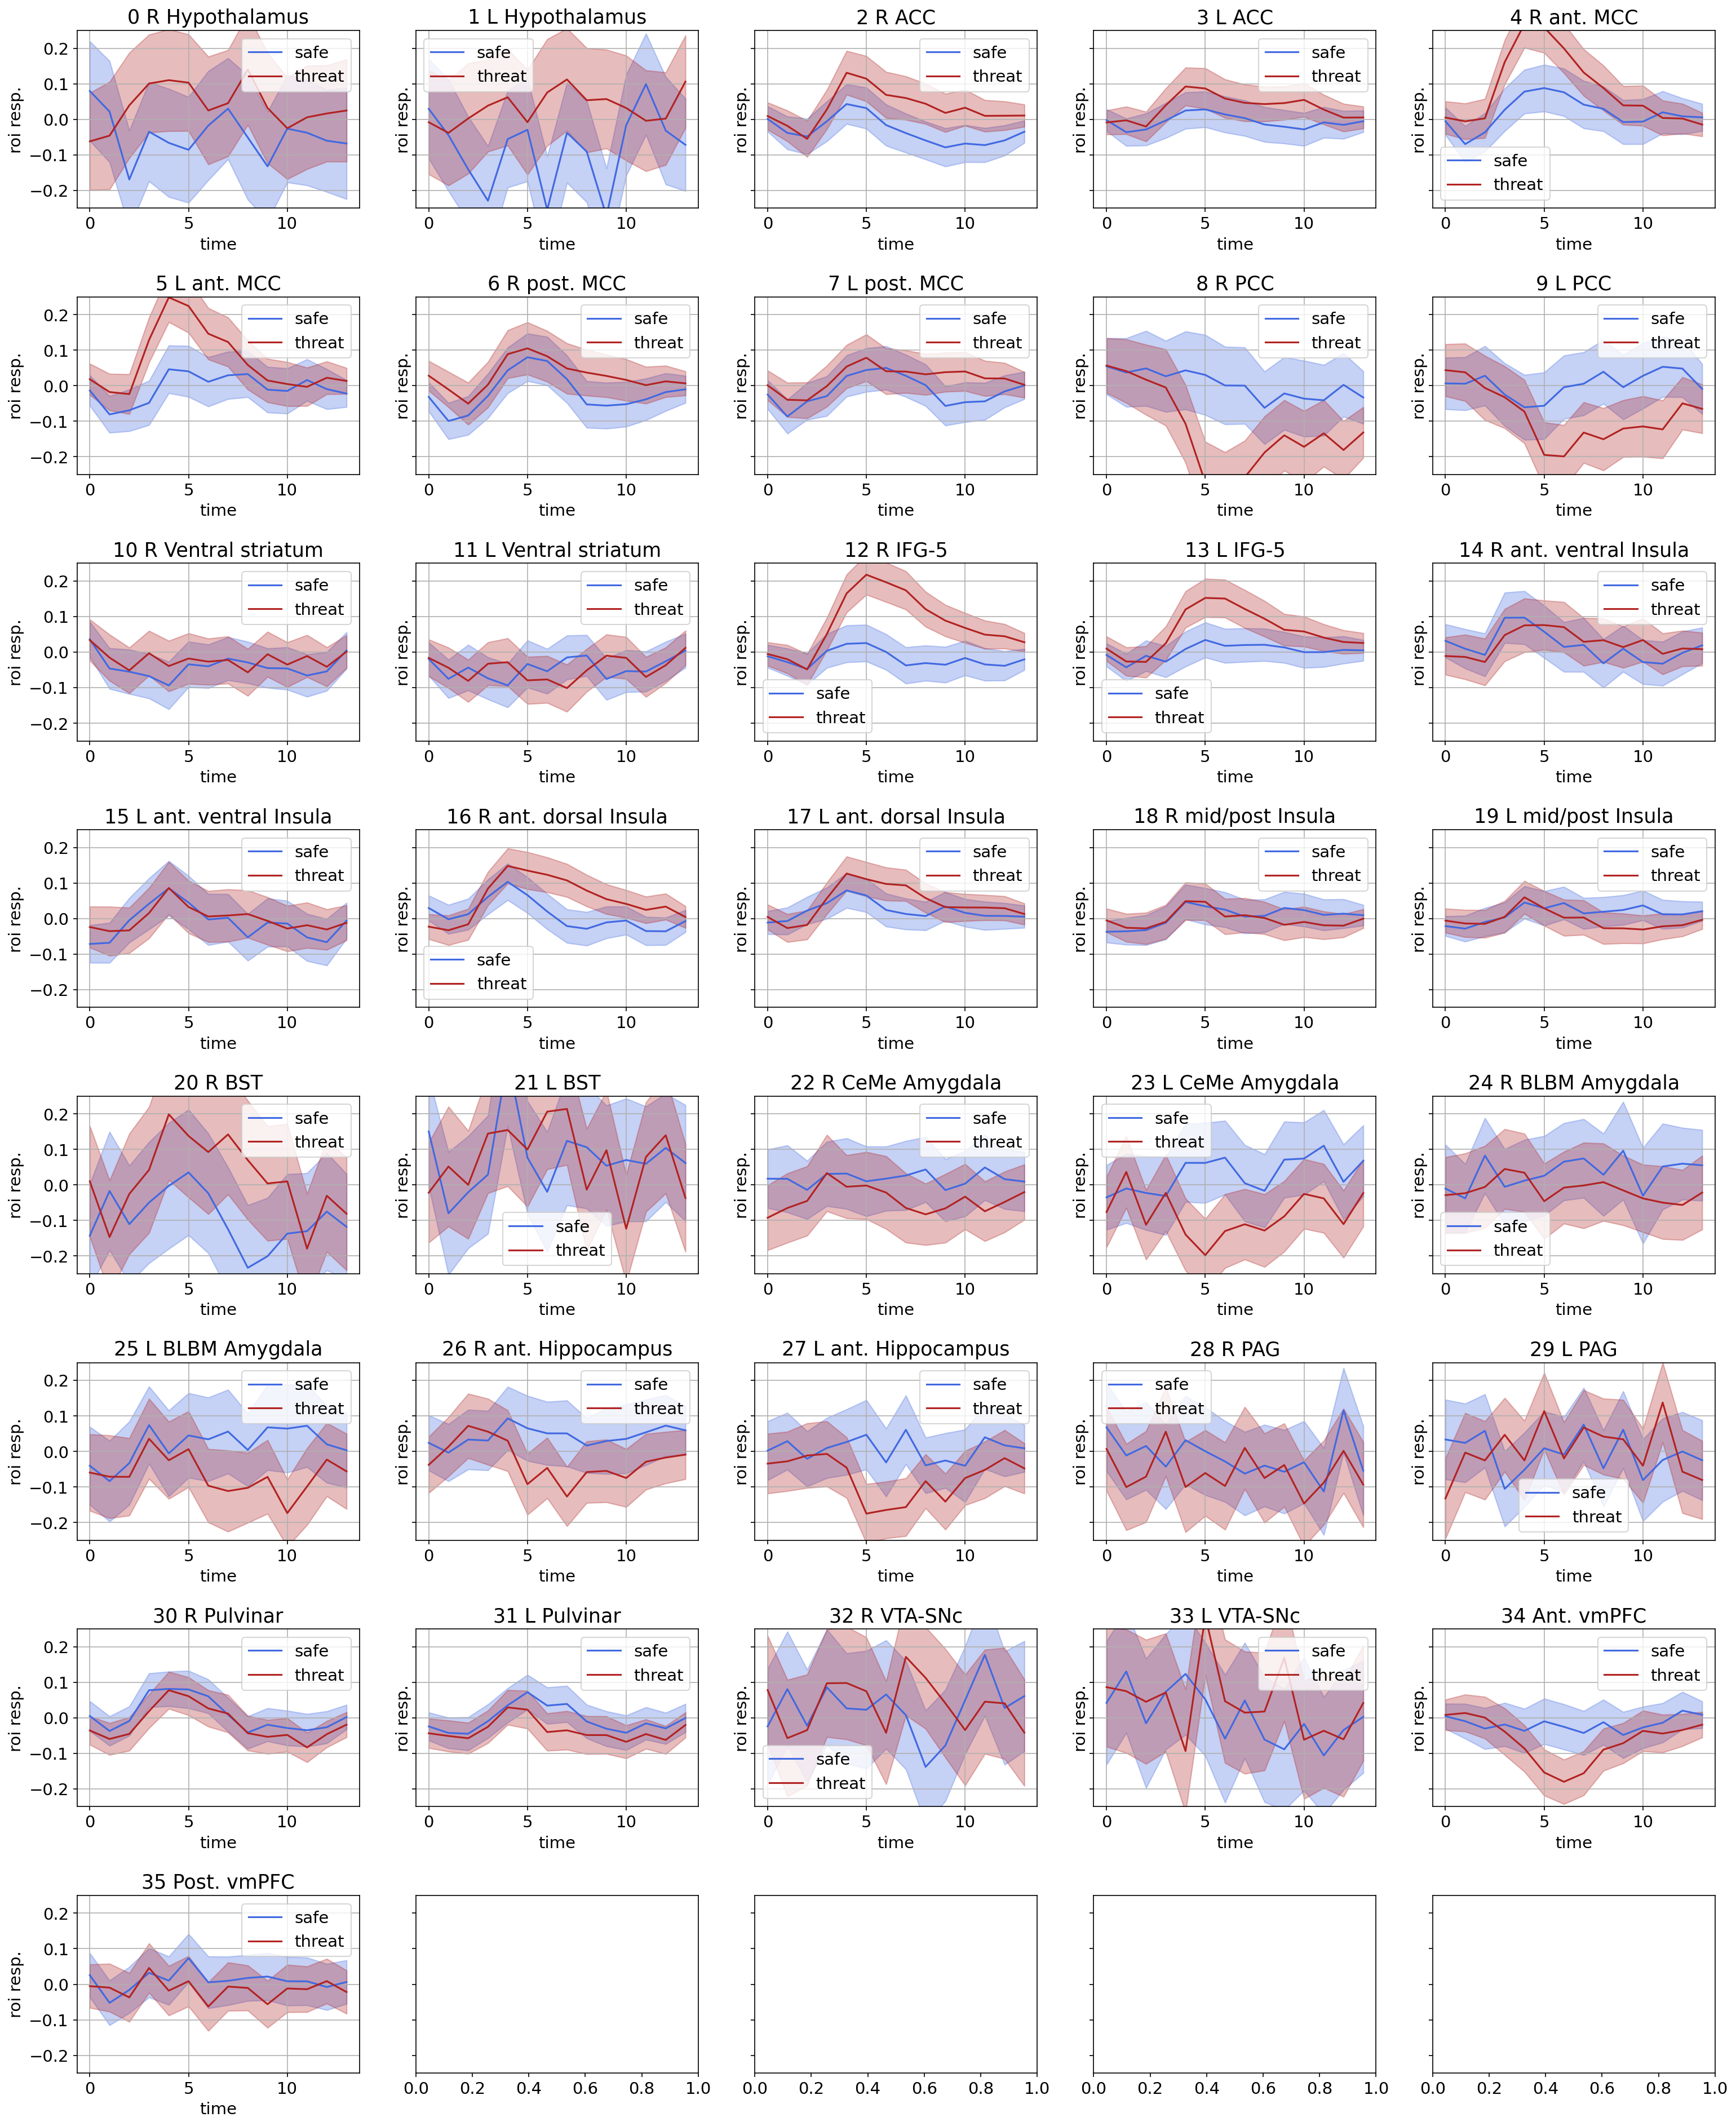

In [8]:
plot_roi_time_series(args, X)